# Imports and loading the biofilm images
loaded in a sample of 6 biofilms and their release cells to create a rough pipeline with the discrete cosine transform

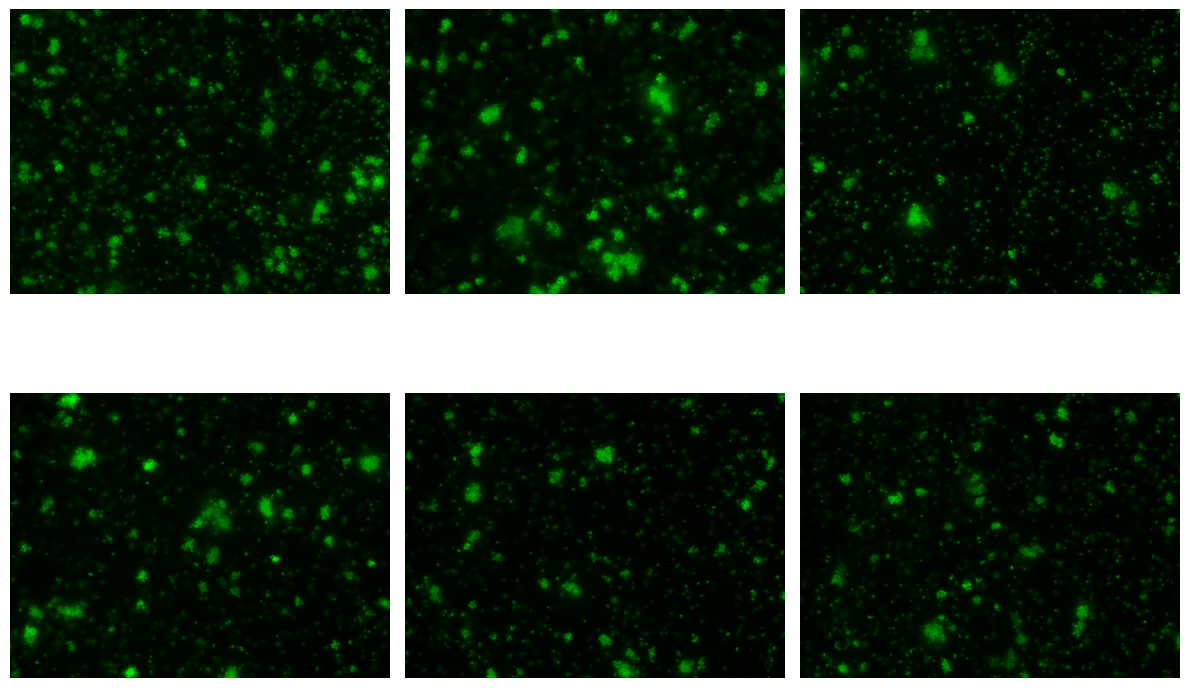

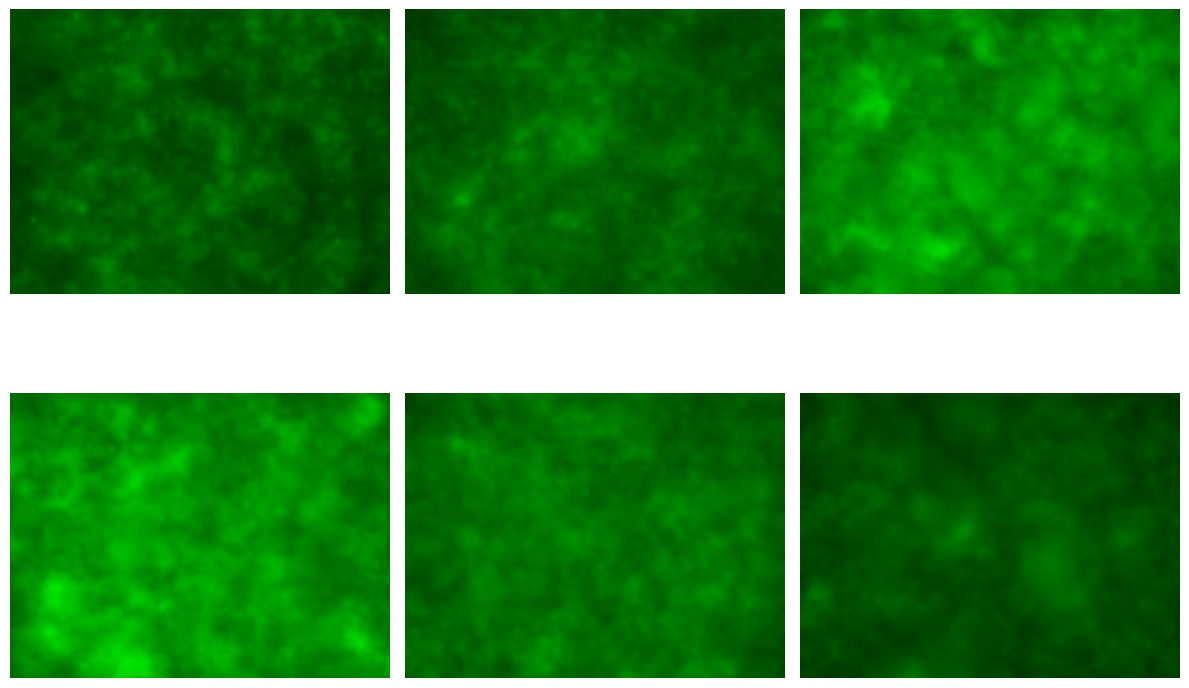

In [37]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('vendor').resolve()))
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import scipy.fftpack
import glob
import importlib
import utils
from utils import load_images, display_image, grayscale, normalize, display_grid_of_images, fft_dct
importlib.reload(utils)
#for Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load and display release cell images
release_imgs = []
release_pre_imgs = load_images('biofilm_data/release_cells/Untreated')
display_grid_of_images(release_pre_imgs)
for i in range(len(release_pre_imgs)):
    z = grayscale(release_pre_imgs[i])
    z = normalize(z)
    release_imgs.append(z)


# Load and display biofilm images
biofilm_imgs = load_images('biofilm_data/biofilm/Untreated')
display_grid_of_images(biofilm_imgs)

### Discrete Cosine Transforming
Taking the loaded release cell images and transforming them using the discrete cosine transformation. After transforming them, putting them into a dataframe. the Biofilm images were also put into a dataframe and then found the average cell brightness value to use as a predictor.

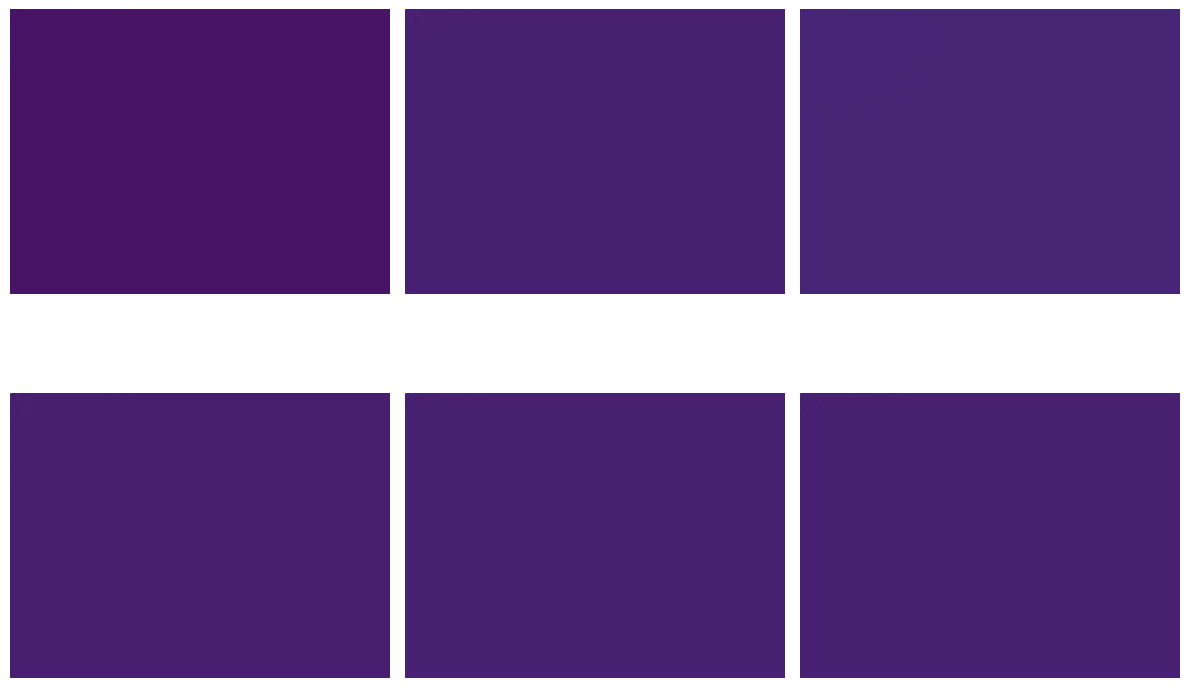

In [38]:
dct_release_imgs = []
for i in range(len(release_pre_imgs)):
    image = normalize(release_pre_imgs[i])
    image = grayscale(image)
    dct_release_img = fft_dct(image)
    dct_release_imgs.append(dct_release_img)
display_grid_of_images(dct_release_imgs)

In [39]:
# convert list of dct images to list of dataframes
dct_release_imgs_df = []
for i in range(len(dct_release_imgs)):
    df = pd.DataFrame(dct_release_imgs[i])
    dct_release_imgs_df.append(df)
print(dct_release_imgs_df[0].head())

# flatten each dataframe to 1D array
dct_release_imgs_flat = [df.values.flatten() for df in dct_release_imgs_df]

             0            1             2            3            4    \
0  112386.133333 -2818.237596  11242.404076 -2885.582400  2600.299167   
1   -6385.031111  5001.782887   1334.581020  2252.696966  2507.793948   
2    1216.234099  3688.208299   -784.464617  3557.467306 -4266.595953   
3    4116.490364  -750.321742   3483.948599 -2915.565816  2142.426458   
4   -2783.995652  1334.073341   1395.260561  1029.901358   920.861144   

           5            6            7            8            9    ...  \
0 -2733.918282  1888.478283 -2844.186030  4427.859787   920.398439  ...   
1  2859.885254 -2914.036422  1457.973261 -2707.855449 -1250.482536  ...   
2  -960.872019   996.794447   822.720828   189.252054 -1805.242211  ...   
3  2604.673217 -2637.763840  1735.651269   -69.151736  -329.892254  ...   
4 -3664.916633  1199.746067   697.642194   -21.484048  1564.448778  ...   

         630        631        632        633        634        635  \
0 -13.735056 -13.780076  19.336046  -2.

In [40]:
# convert list of biofilm images to list of dataframes
biofilm_imgs_df = []
for i in range(len(biofilm_imgs)):
    df = pd.DataFrame(grayscale(biofilm_imgs[i]))
    biofilm_imgs_df.append(df)

#average biofilm brightness to have a certain value to predict
avg_biofilm_brightness = []
for i in range(len(biofilm_imgs_df)):
    avg_brightness =biofilm_imgs_df[i].values.mean()
    avg_biofilm_brightness.append(avg_brightness)

### Modeling (Random Forest)
not the best model we assume for right now but quick and simple demonstration of utilization and comparison

In [41]:
# Split data into training and testing sets (80% train, 20% test)
x_dct_train, x_dct_test, y_dct_train, y_dct_test = train_test_split(dct_release_imgs_flat, avg_biofilm_brightness, test_size=0.2, random_state=42)

In [42]:
#Random Forest Regressor modeling
RF = RandomForestRegressor(n_estimators=100, random_state=42)

RF.fit(x_dct_train, y_dct_train)
y_pred = RF.predict(x_dct_test)

# Compute MSE by hand
mse = 0
for y_true, y_prediction in zip(y_dct_test, y_pred):
    mse += (y_true - y_prediction) ** 2
mse = mse / len(y_dct_test)

print("MSE:", mse)

MSE: 741.2848679242322


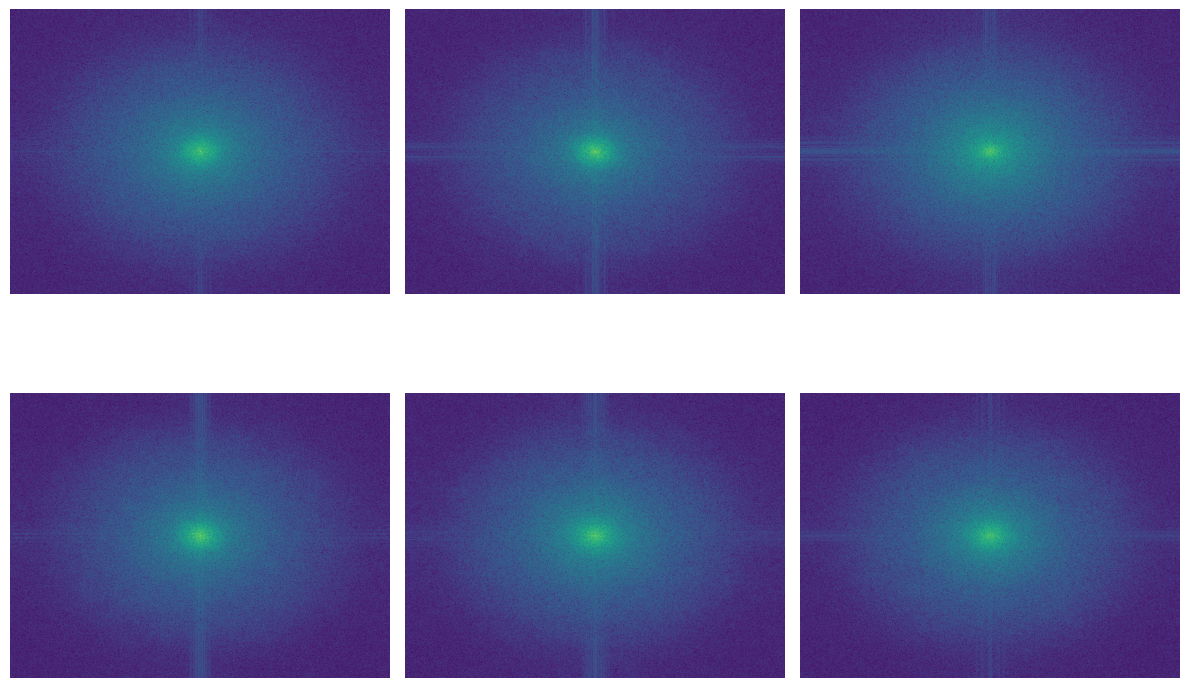

In [43]:
import scipy.fft
release_fft_imgs = []
for i in range(len(release_imgs)):
    fft_image = scipy.fft.fft2(release_imgs[i])
    mag = np.abs(scipy.fft.fftshift(fft_image))
    mag = np.log1p(mag)
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-12)      
    release_fft_imgs.append(mag)

display_grid_of_images(release_fft_imgs)

In [44]:
# convert list of fft images to list of dataframes
fft_release_imgs_df = []
for i in range(len(release_fft_imgs)):
    df = pd.DataFrame(release_fft_imgs[i])
    fft_release_imgs_df.append(df)
print(fft_release_imgs_df[0].head())

# flatten each dataframe to 1D array
fft_release_imgs_flat = [df.values.flatten() for df in fft_release_imgs_df]

        0         1         2         3         4         5         6    \
0  0.152241  0.076102  0.095909  0.137223  0.063162  0.041772  0.089158   
1  0.146288  0.042612  0.080589  0.084280  0.130248  0.051937  0.115088   
2  0.085810  0.097356  0.133367  0.136110  0.057915  0.122910  0.090491   
3  0.119574  0.124242  0.027640  0.036819  0.079057  0.157795  0.062909   
4  0.020551  0.087589  0.118897  0.097067  0.102588  0.112725  0.084419   

        7         8         9    ...       630       631       632       633  \
0  0.119664  0.066539  0.160952  ...  0.112861  0.160952  0.066539  0.119664   
1  0.154428  0.108025  0.066598  ...  0.084786  0.168703  0.072695  0.168829   
2  0.082089  0.084350  0.051055  ...  0.125484  0.048084  0.131835  0.146035   
3  0.181563  0.094372  0.011100  ...  0.164927  0.113727  0.062040  0.104666   
4  0.103639  0.071076  0.147088  ...  0.116508  0.120103  0.083598  0.061740   

        634       635       636       637       638       639  
0  0

In [45]:
# Split data into training and testing sets (80% train, 20% test)
x_fft_train, x_fft_test, y_fft_train, y_fft_test = train_test_split(fft_release_imgs_flat, avg_biofilm_brightness, test_size=0.2, random_state=42)

In [46]:
#Random Forest Regressor modeling
RF = RandomForestRegressor(n_estimators=100, random_state=42)

RF.fit(x_fft_train, y_fft_train)
y_pred = RF.predict(x_fft_test)

# Compute MSE by hand
mse = 0
for y_true, y_prediction in zip(y_fft_test, y_pred):
    mse += (y_true - y_prediction) ** 2
mse = mse / len(y_fft_test)

print("MSE:", mse)

MSE: 719.7203570189861


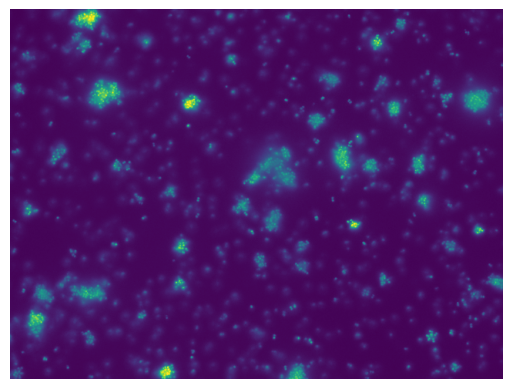

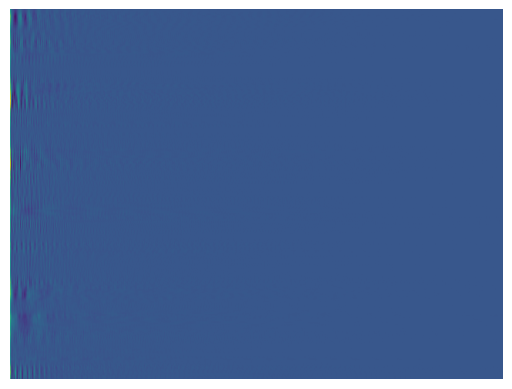

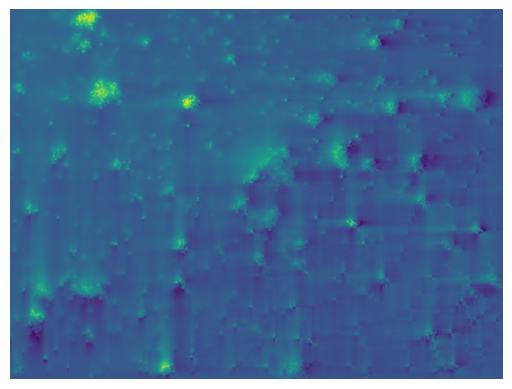

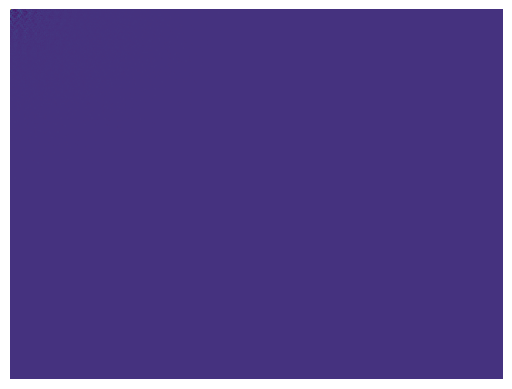

Max Error: 176.71764705882356


In [136]:
x = release_imgs[3]
display_image(x)
display_image(scipy.fft.dct(x))
display_image(scipy.fft.dctn(scipy.fft.dctn(x.T, type=2, norm='ortho').T, type=2, norm='ortho'))
display_image(scipy.fft.dctn(x, type=2, norm='ortho'))
#display_image(scipy.fft.idct(scipy.fft.idct(x)))

diff = np.abs(release_imgs[0] - (scipy.fft.dct(x)))
print("Max Error:", diff.max())

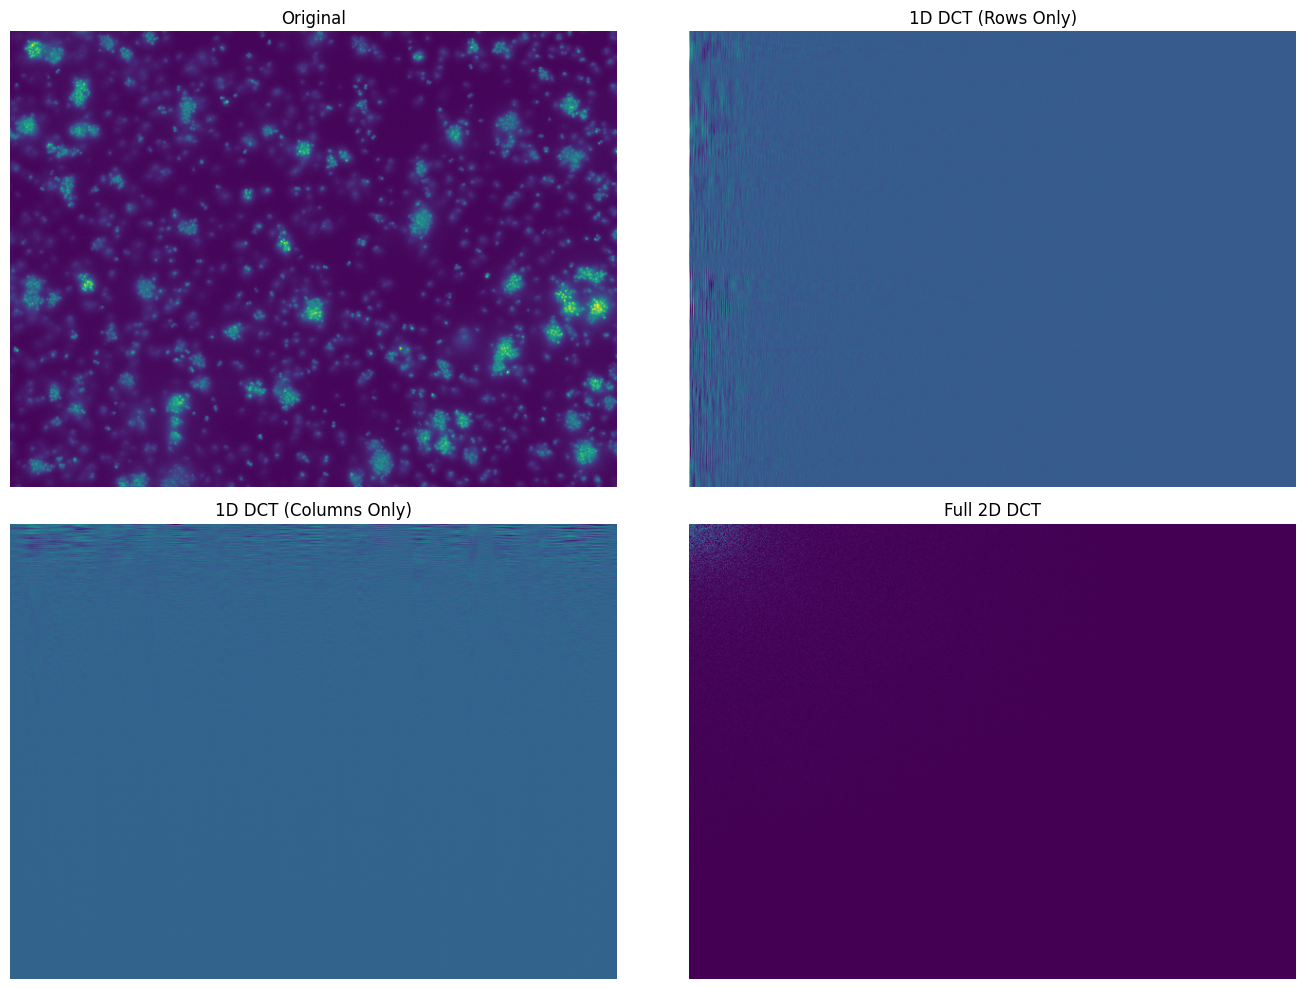

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from PIL import Image

# Load your image (replace path if needed)
img = release_imgs[0]

# 1D DCT along rows
dct_rows = dct(img, axis=1, norm='ortho')

# 1D DCT along columns
dct_cols = dct(img, axis=0, norm='ortho')

# 2D DCT
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

dct_full = dct2(img)

# Log magnitude for all
log_rows = np.log(np.abs(dct_rows) + 1)
log_cols = np.log(np.abs(dct_cols) + 1)
log_full = np.log(np.abs(dct_full) + 1)

# Plot
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(img, cmap='viridis')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("1D DCT (Rows Only)")
plt.imshow(dct_rows, cmap='viridis')
plt.axis('off')

plt.subplot(2,2,3)
plt.title("1D DCT (Columns Only)")
plt.imshow(dct_cols, cmap='viridis')
plt.axis('off')

plt.subplot(2,2,4)
plt.title("Full 2D DCT")
plt.imshow(log_full, cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()
